# Transfer Learning Practice
개미, 벌 이미지 학습 및 분류 <br>
Google Colab<br>
Hymenoptera Data

1. Module Import, Load Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.0.1+cu118  Device: cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
# Kaggle Dataset 다운로드
from google.colab import files
!pip install -q kaggle
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d ajayrana/hymenoptera-data

Saving kaggle.json to kaggle.json
kaggle.json
100% 90.0M/90.2M [00:01<00:00, 83.1MB/s]
100% 90.2M/90.2M [00:01<00:00, 74.1MB/s]


In [5]:
# 파일 리스트 확인
!ls

hymenoptera-data.zip  kaggle.json  sample_data


In [6]:
# 압축 해제
!unzip hymenoptera-data.zip

Archive:  hymenoptera-data.zip
  inflating: hymenoptera_data/hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/hymenopte

In [7]:
# 일부 파일 경로 수정
! mv hymenoptera_data/hymenoptera_data/train/bees/* hymenoptera_data/train/bees/ 
! mv hymenoptera_data/hymenoptera_data/train/ants/* hymenoptera_data/train/ants/
! mv hymenoptera_data/hymenoptera_data/val/bees/* hymenoptera_data/val/bees/
! mv hymenoptera_data/hymenoptera_data/val/ants/* hymenoptera_data/val/ants/
! rm -r hymenoptera_data/hymenoptera_data/

In [8]:
# ImageNet 데이터셋의 RGB Pixel 평균, 표준편차 사용하여 정규화
# train, test 데이터 분리
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet 데이터셋의 RGB Pixel값 평균과 표준편차 사용
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet 데이터셋의 RGB Pixel값 평균과 표준편차 사용
    ]),
}

image_datasets = {x: datasets.ImageFolder("hymenoptera_data", data_transforms[x]) for x in ['train', 'val']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, num_workers = 0, shuffle = True) for x in ['train', 'val']}
dataloaders = {}
for x in ['train', 'val']:
  if x == 'train':
    dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, num_workers = 0, shuffle = True)
  else:
    dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, num_workers = 0, shuffle = False)  

In [9]:
# 데이터 확인
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


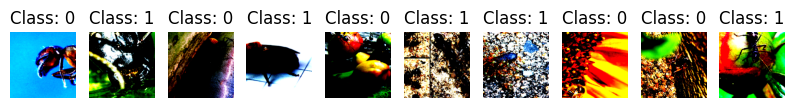

In [10]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

2. Train & Eval

In [11]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [12]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [13]:
# Pytorch ResNet18 모델 불러오기
import torchvision.models as models

model = models.resnet18(pretrained = False)
# Fully Connected Layer Output 노드 수 2개(개미, )로 설정
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [14]:
# Optimizer, Objective Function 설정
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    test_loss, test_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.717093
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.925095
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.802794

[EPOCH: 1], 	Test Loss: 0.0410, 	Test Accuracy: 46.35 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.673454
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.772329
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.653560

[EPOCH: 2], 	Test Loss: 0.0427, 	Test Accuracy: 56.17 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.741981
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.773178
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.721205

[EPOCH: 3], 	Test Loss: 0.0387, 	Test Accuracy: 55.16 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.661804
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.734145
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.776085

[EPOCH: 4], 	Test Loss: 0.0236, 	Test Accuracy: 58.69 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.667186
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.724790
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.858621

In [16]:
# IMAGENET 데이터로 미리 학습된 ResNet18 모델 불러온 후 hymenoptera 데이터에 맞춰 Fine Tuning
model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 264MB/s]


Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.586127
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.746002
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.782941

[EPOCH: 1], 	Test Loss: 0.0208, 	Test Accuracy: 68.77 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.539066
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.541747
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.491036

[EPOCH: 2], 	Test Loss: 0.0172, 	Test Accuracy: 75.57 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.525026
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.397479
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.465852

[EPOCH: 3], 	Test Loss: 0.0152, 	Test Accuracy: 80.86 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.393234
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.393732
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.372731

[EPOCH: 4], 	Test Loss: 0.0126, 	Test Accuracy: 87.66 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.371287
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.359021
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.245480